In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys
import json

import torch
import torch.nn as nn
from torchvision import transforms, datasets
import torch.optim as optim
from tqdm import tqdm

In [ ]:
from torchvision import models
import pandas as pd

In [ ]:
vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))

    data_transform = {
        "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
        "val": transforms.Compose([transforms.Resize((224, 224)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

    data_root = '/content/drive/MyDrive/data'  # get data root path
    image_path = os.path.join(data_root)  # flower data set path
    assert os.path.exists(image_path), "{} path does not exist.".format(image_path)
    train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "train"),
                                         transform=data_transform["train"])
    train_num = len(train_dataset)


    bird_list = train_dataset.class_to_idx
    cla_dict = dict((val, key) for key, val in bird_list.items())
    # write dict into json file
    json_str = json.dumps(cla_dict, indent=4)
    with open('/content/drive/MyDrive/model/class_indices_vgg_400bird.json', 'w') as json_file:
        json_file.write(json_str)

    batch_size = 256
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    print('Using {} dataloader workers every process'.format(nw))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size, shuffle=True,
                                               num_workers=nw)

    validate_dataset = datasets.ImageFolder(root=os.path.join(image_path, "valid"),
                                            transform=data_transform["val"])
    val_num = len(validate_dataset)
    validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                                  batch_size=batch_size, shuffle=False,
                                                  num_workers=nw)
    print("using {} images for training, {} images for validation.".format(train_num,
                                                                           val_num))

    # test_data_iter = iter(validate_loader)
    # test_image, test_label = test_data_iter.next()

    # model_name = "vgg16"
    # net = vgg(model_name=model_name, num_classes=400, init_weights=True)
    # net.to(device)
    # loss_function = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(net.parameters(), lr=0.001)

    net = vgg16
    for param in net.parameters():
        param.requires_grad = False

    # change fc layer structure
    net.classifier[6] = nn.Linear(4096,400)
    net.to(device)

    # define loss function
    loss_function = nn.CrossEntropyLoss()

    # construct an optimizer
    params = [p for p in net.parameters() if p.requires_grad]
    optimizer = optim.Adam(params, lr=0.001)

    epochs = 10
    best_acc = 0.0
    save_path = '/content/drive/MyDrive/model/VGG_400bird.pth'
    train_steps = len(train_loader)

    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    for epoch in range(epochs):
        # train
        net.train()
        running_loss = 0.0
        num_correct = 0.0
        train_bar = tqdm(train_loader, file=sys.stdout)
        for step, data in enumerate(train_bar):
            images, labels = data
            optimizer.zero_grad()
            outputs = net(images.to(device))
            loss = loss_function(outputs, labels.to(device))
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            pred = torch.max(outputs, dim=1)[1]
            num_correct += torch.eq(pred, labels.to(device)).sum().item()

            train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                     epochs,
                                                                     loss)

        # validate
        net.eval()
        acc = 0.0  # accumulate accurate number / epoch
        vali_loss = 0.0
        with torch.no_grad():
            val_bar = tqdm(validate_loader, file=sys.stdout)
            for val_data in val_bar:
                val_images, val_labels = val_data
                outputs = net(val_images.to(device))
                loss = loss_function(outputs, val_labels.to(device))
                predict_y = torch.max(outputs, dim=1)[1]
                acc += torch.eq(predict_y, val_labels.to(device)).sum().item()
                vali_loss += loss.item()

                val_bar.desc = "valid epoch[{}/{}]".format(epoch + 1,
                                                           epochs)

        val_accurate = acc / val_num
        print('[epoch %d] train_loss: %.3f  train_accuracy: %.3f  val_loss: %.3f  val_accuracy: %.3f' %
              (epoch + 1, running_loss / train_steps, num_correct / len(train_loader.dataset), vali_loss / len(validate_loader), val_accurate))
        
        train_loss.append(running_loss / train_steps)
        val_acc.append(val_accurate)
        train_acc.append(num_correct / len(train_loader.dataset))
        val_loss.append(vali_loss / len(validate_loader))


        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)

    print('Finished Training')
    return train_loss, train_acc, val_loss, val_acc


if __name__ == '__main__':
    train_loss, train_acc, val_loss, val_acc = main()

using cuda:0 device.
Using 2 dataloader workers every process
using 58388 images for training, 2000 images for validation.
valid epoch[1/10]: 100%|██████████| 8/8 [00:12<00:00,  1.56s/it]
[epoch 1] train_loss: 2.770  train_accuracy: 0.399  val_loss: 0.866  val_accuracy: 0.781
valid epoch[2/10]: 100%|██████████| 8/8 [00:11<00:00,  1.48s/it]
[epoch 2] train_loss: 1.984  train_accuracy: 0.529  val_loss: 0.649  val_accuracy: 0.834
valid epoch[3/10]: 100%|██████████| 8/8 [00:12<00:00,  1.59s/it]
[epoch 3] train_loss: 1.905  train_accuracy: 0.547  val_loss: 0.593  val_accuracy: 0.842
valid epoch[4/10]: 100%|██████████| 8/8 [00:12<00:00,  1.50s/it]
[epoch 4] train_loss: 1.849  train_accuracy: 0.558  val_loss: 0.536  val_accuracy: 0.856
valid epoch[5/10]: 100%|██████████| 8/8 [00:12<00:00,  1.62s/it]
[epoch 5] train_loss: 1.805  train_accuracy: 0.567  val_loss: 0.500  val_accuracy: 0.868
valid epoch[6/10]: 100%|██████████| 8/8 [00:11<00:00,  1.49s/it]
[epoch 6] train_loss: 1.775  train_accurac

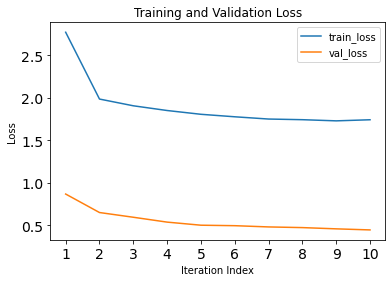

In [ ]:
df_loss = pd.DataFrame(data = {'train_loss':train_loss, 'val_loss':val_loss}, index = [1,2,3,4,5,6,7,8,9,10] )
df_loss.plot(xticks=[1,2,3,4,5,6,7,8,9,10], title='Training and Validation Loss', fontsize=14, xlabel='Iteration Index', ylabel='Loss')

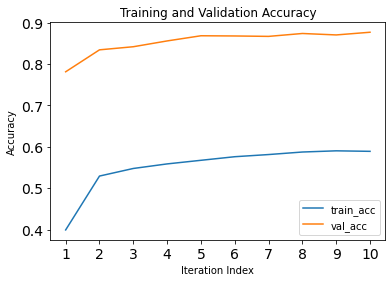

In [ ]:
df_acc = pd.DataFrame(data = {'train_acc':train_acc, 'val_acc':val_acc}, index = [1,2,3,4,5,6,7,8,9,10] )
df_acc.plot(xticks=[1,2,3,4,5,6,7,8,9,10], title='Training and Validation Accuracy', fontsize=14, xlabel='Iteration Index', ylabel='Accuracy')